# Plot surface streamlines on LLC4320

Author: Wenrui Jiang 14 June, 2023

The LLC4320 ocean circulation model solution is a kilometer-scale, global simulation with complex grid topology. This is a good dataset to test the performance of the `seaduck` package.

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm
import numpy as np
from matplotlib.collections import LineCollection
import matplotlib as mpl
import oceanspy as ospy

import seaduck as sd

mpl.rcParams["figure.dpi"] = 600

```{admonition} Access LLC4320
The global MITgcm run is the LLC4320 simulation and is publicly available on [SciServer](sciserver.org) (from the Oceanography container). The simulation output can be opened using the [OceanSpy](https://github.com/hainegroup/oceanspyhttps://github.com/hainegroup/oceanspy) package using the [`from_catalog`](https://oceanspy.readthedocs.io/en/latest/generated/oceanspy.open_oceandataset.from_catalog.html#oceanspy.open_oceandataset.from_catalog) method. 

`ecco = ospy.open_oceandataset.from_catalog("LLC4320")`

Click [here](https://dev-poseidon-ocean.pantheonsite.io/products/datasets/) for a full list of the SciServer datasets.
```

## Calculate the streamlines online

First we get the dataset into `OceData` object with help from `OceanSpy`. This step requires the grid to be loaded into memory as `numpy` arrays and then create the cKD tree on top of that, so it's going to take some time.

In [2]:
od = ospy.open_oceandataset.from_catalog("LLC4320")
ds = od._ds
oce = sd.OceData(ds)

Opening LLC4320.


10 day hourly data from the LLC4320 simulations computed using the MITGCM, a general, curvilinear ocean simulation on the cube-sphere.


Initiate the particles randomly, so that they're distributed evenly on the globe. Use `N` = $1.5 \\times 10^5$ particles.

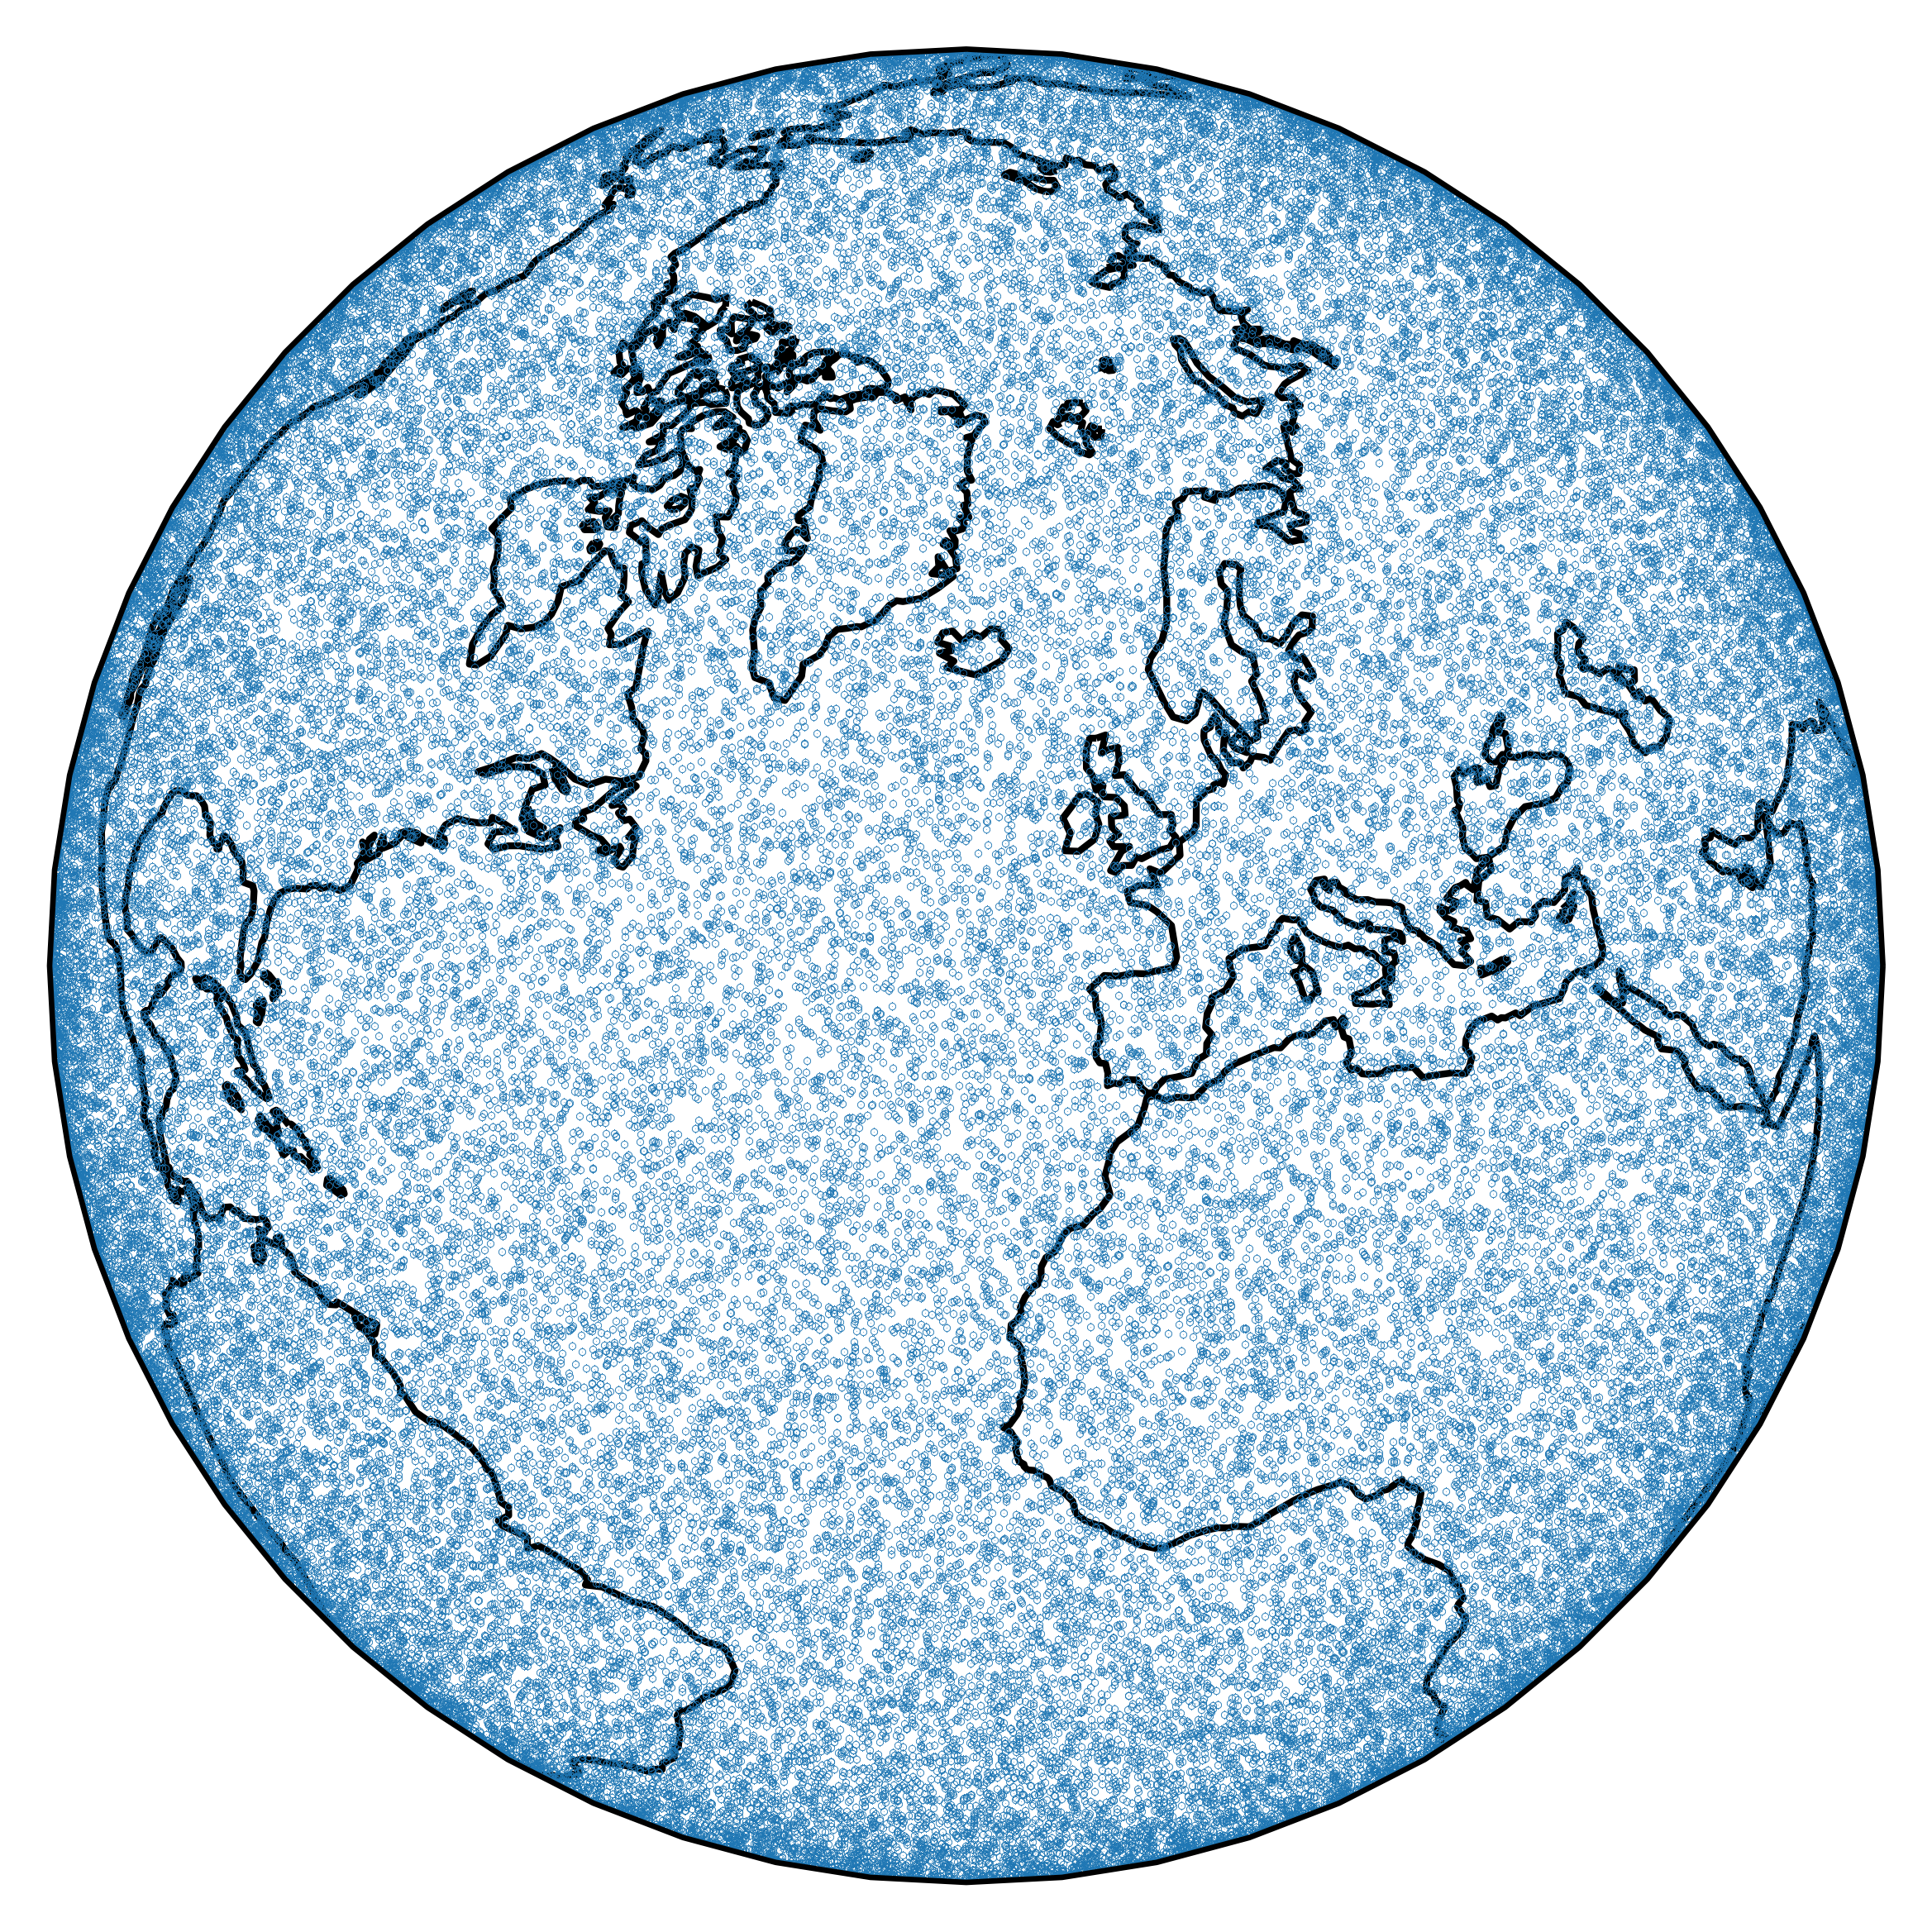

In [3]:
N = int(1.5e5)
np.random.seed(4320)
xx, yy, zz = [np.random.normal(size=N) for i in range(3)]
r = np.sqrt(xx**2 + yy**2 + zz**2)
y = (np.pi / 2 - np.arccos(zz / r)) * 180 / np.pi
x = np.arctan2(yy, xx) * 180 / np.pi
x = x[y > -80]
y = y[y > -80]
z = np.ones_like(x) * (-10.0)
t = np.ones_like(x) * 10.0

ax = plt.axes(
    projection=ccrs.Orthographic(central_longitude=-20.0, central_latitude=45.0)
)
ax.plot(x, y, "o", markersize=0.1, transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

We'll use just one vertical layer (the first one, which is at the surface) of a single snapshot (the first one) to make the streamlines.

In [4]:
oce["u"] = oce["U"][0, 0]
oce["v"] = oce["V"][0, 0]

By setting `wname = None`, we fix particles to move on a horizontal surface. Think of isobaric floats.

In [5]:
%%time
p = sd.Particle(
    x=x,
    y=y,
    z=z,
    t=t,
    data=oce,
    uname="u",
    vname="v",
    wname=None,
)

CPU times: user 1min 19s, sys: 8.16 s, total: 1min 27s
Wall time: 1min 26s


The package knows that LLC4320 is a large dataset, so by default it doesn't prefetch data. Otherwise, `seaduck` is overwhelmed. In general, this is a smart thing to do.

However, since we are using a static 2D velocity field here, which is much smaller than the 3D time-varying field, we actually have enough memory to prefetch. So tell `seaduck` this bit of LLC4320 isn't overwhelmingly big:

In [6]:
p.too_large = False

In [7]:
p.uarray = np.array(oce["u"])
p.varray = np.array(oce["v"])

Everything went well. Now, we are going to compute trajectories with a 3 hour timestep for 30 days. This will take a while: time for a nap...

In [8]:
step = 10800
N = 240
dest = [n * step for n in range(1, N)]

In [9]:
%%time
stops, raw = p.to_list_of_time(dest, update_stops=[])

ValueError: Particle way out of bound.tend = 6, the_t = 10799.999999993917, rx = -0.20219270391113148,ry = -1.6693495805570682,rz = -0.15454535799578412start with u = 4.695701621346472e-06, du = -5.773571643116384e-05, x=-0.009470161238869457start with v = -1.4674619307268205e-05, dv = -2.8246484204894833e-06, y=0.08627583529220939start with w = 0.0, dw = -2.8246484204894833e-06, z=0.3454546420042159

It took around 3 hours to run a month of simulation for $1.5\times 10^{5}$ particles. We can now extract the things we need to plot, namely longitude, latitude, and horizontal speed.

In [10]:
lons = np.array([i.lon for i in raw])
lats = np.array([i.lat for i in raw])
spds = np.array([np.hypot(i.u * i.dx, i.v * i.dy) for i in raw])

NameError: name 'raw' is not defined

If you would like to save the data for plotting, you can change the following raw block to code block and run it.

If the location and speed is already pre-computed, they can be loaded by:

## Plotting Preparation

The [ETOPO](https://www.ncei.noaa.gov/products/etopo-global-relief-model) topography dataset is also accessible on SciServer using `OceanSpy`. This will give us absolutely beautiful plots.

In [ ]:
etopo = ospy.open_oceandataset.from_catalog("ETOPO")

For this notebook, we only need the land, because there is already so much going on in the water. So clip the `etopo` data.

In [ ]:
etopo = etopo._ds.where(etopo._ds.Depth > 0)

Here is the function for plotting. The lines will be colored with speed. This part is going to take some time, but I hope you find it worth the wait.

In [ ]:
def pretty_stream_plot(
    lats,
    lons,
    spds,
    projection,
    particle_bins=1,
    bins=5,
    north=1000,
    south=-1000,
    plot_lines=True,
    save_as=None,
):
    plt.figure(figsize=(16, 16))
    axs = plt.axes(projection=projection)
    axs.set_extent([-1e4, 1e4, south, north], crs=ccrs.PlateCarree())
    plt.tight_layout()
    axs.pcolormesh(
        etopo.X[::bins],
        etopo.Y[::bins],
        etopo.Depth[::bins, ::bins],
        transform=ccrs.PlateCarree(),
        cmap="bone",
        vmin=-3000,
        vmax=4500,
        zorder=20,
    )
    axs.set_facecolor("lightsteelblue")
    print("finished making the map")
    if not plot_lines:
        print("skipping the lines")
        return
    # To speed up the computation, we transform the
    # latlon outside the for plotting for-loop.
    xx, yy, _ = projection.transform_points(ccrs.PlateCarree(), lons, lats).T

    xx = xx.T
    yy = yy.T

    for i in tqdm(range(0, lons.shape[1], particle_bins)):
        y = yy.T[i][1:]
        x = xx.T[i][1:]
        if np.max(x) - np.min(x) > 300:
            x[x < 0] += 360
        dydx = (0.5 * (spds.T[i][:-1] + spds.T[i][1:]))[1:]  # first derivative

        # Create a set of line segments so that we can color them individually
        # This creates the points as a N x 1 x 2 array so that we can stack points
        # together easily to get the segments. The segments array for line collection
        # needs to be (numlines) x (points per line) x 2 (for x and y)
        points = np.array([x, y]).T.reshape(-1, 1, 2)

        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Create a continuous norm to map from data points to colors
        norm = plt.Normalize(0, 1.0)
        lc = LineCollection(segments, cmap="GnBu_r", norm=norm)
        # Set the values used for colormapping
        lc.set_array(dydx)
        lc.set_linewidth(0.3)
        axs.add_collection(lc)

    if save_as is not None:
        plt.savefig(save_as)

## Voila!

### Looking from the Arctic

In [ ]:
north_projection = ccrs.NorthPolarStereo(central_longitude=38.0)
pretty_stream_plot(
    lats,
    lons,
    spds,
    north_projection,
    south=6.5,
    save_as="LLC4320_files/LLC4320_29_2.png",
)
plt.show()

**Fig.1** Streamlines of 150,000 particles released at 00:00 Apr 25, 2012 in LLC4320 simulated for 30 days. The color shading shows the current speed. This is looking from the North Pole.

### Looking from the Antarctic

In [ ]:
south_projection = ccrs.SouthPolarStereo(central_longitude=38.0)
pretty_stream_plot(
    lats,
    lons,
    spds,
    south_projection,
    north=-6.5,
    save_as="LLC4320_files/LLC4320_32_2.png",
)
plt.show()

**Fig.2** Similar to **Fig.1**, but looking from the South Pole.